Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Iga Miller"

---

# 1. Grafowe sieci neuronowe

W niniejszym zeszycie opiszemy i przeprowadzimy ewaluację 3 najpopularniejszych architektur grafowych sieci neuronowych, mianowicie:
- Graph Convolutional Network (**GCN**)
- Graph Sample and Aggregate (**GraphSAGE**)
- Graph Attention Network (**GAT**)

Wykorzystamy poznany w ramach poprzedniego laboratorium zbiór Cora i sprawdzimy jakość działania powyższych modeli w zadaniu klasyfikacji węzłów. Implementacje modeli są dostępne w bibliotece PyTorch-Geometric, natomiast do uczenia modeli wykorzystamy bibliotekę PyTorch-Lightning.

## 1.1. Załadowanie zbioru
Zbiory danych w PyTorch-Lightningu są przekazywane jako instancje obiektów `DataLoader` do metody `fit()` klasy `Trainer`. Można jednak użyć klasy `LightningDataModule` i w niej zdefiniować wszystkie data loadery wraz z wczytaniem właściwego zbioru. Zauważmy, że dotychczas rozważany zbiór danych Cora nie jest podzielony na mniejsze części (tj. mamy dokładnie jeden obiekt `Data`, który opisuje cały graf). Można wykorzystywać metody próbkowania grafów (np. `NeighborSampler`) i przez to uzyskać podział na mini-paczki, jednak zbiór Cora jest na tyle mały, że nie opłaca się go bardziej dzielić. Wykorzystamy natomiast fakt, że wczytywany obiekt `Planetoid` jest iterowalny i zwiera dokładnie jeden element. Możemy go zatem opakować w obiekt `DataListLoader` (dedykowana wersja `DataLoader`a zaimplementowana w PyTorch-Geometricu).

In [1]:
from IPython.display import Code, display

display(Code("src/dataset.py"))

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataListLoader
from torch_geometric.datasets import Planetoid


class GraphData(pl.LightningDataModule):

    def __init__(self, dataset_name: str):
        super().__init__()

        self._dataset = self._load(dataset_name)

    def train_dataloader(self) -> DataLoader:
        return self._dataloader()

    def val_dataloader(self) -> DataLoader:
        return self._dataloader()

    def test_dataloader(self) -> DataLoader:
        return self._dataloader()

    def predict_dataloader(self) -> DataLoader:
        return self._dataloader()

    @property
    def num_node_features(self) -> int:
        return self._dataset.num_node_features

    @property
    def num_classes(self) -> int:
        return self._dataset.num_classes

    @property
    def data(self) -> Data:
        return self._dataset[0]

    @staticmethod
    def _load(dataset_name: str) -> Dataset:
        if dataset_name == "Cora":
            dataset = Planetoid(root="./data", name="Cora")
        else:
            raise ValueError(f"Unknown dataset: {dataset_name}")

        return dataset

    def _dataloader(self) -> DataLoader:
        # We can use the same DataLoader for all data splits, as there are
        # masks in the Data object that we will use for selecting the
        # appropriate nodes set. Moreover, we can set `shuffle=False` for all
        # splits, because we have only one `Data` object (there is nothing
        # to shuffle). Notice that we use PyTorch-Geometric's custom data loader
        # object, because the default PyTorch one does not know how to collate
        # `Data` objects in a batch.
        return DataListLoader(
            dataset=self._dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0,
        )

In [2]:
from src.dataset import GraphData


datamodule = GraphData(dataset_name="Cora")

## 1.2. Trenowanie modeli
Wszystkie wymienione modele grafowych sieci neuronowych zostały zaproponowane jako warstwy (z perspektywy głębokiego uczenia maszynowego), które możemy połączyć z dowolnymi innymi warstwami, aby utworzyć model (tzn. możemy wykorzystać znane aktywacje, warstwy liniowe itd.). Istotne dla nas jest jednak to, że grafowe sieci neuronowe (ang. *Graph Neural Networks - GNN*) nie są związane z jakąkolwiek funkcją kosztu i możemy je uczyć zarówno w scenariuszu nadzorowanym jak i nienadzorowanym. Temat modeli nienadzorowanych jest bardziej złożony, zatem na razie go pominiemy i wrócimy do niego w następnym zeszycie.

Na chwilę obecną będziemy rozważać scenariusz nadzorowanej klasyfikacji wierzchołków. Przeanalizujmy implementację klasy `SupervisedNodeClassificationGNN`:

In [3]:
display(Code("src/supervised.py"))

from typing import List, Optional, Tuple

import pytorch_lightning as pl
import torch
from sklearn.metrics import roc_auc_score
from torch import nn
from torch_geometric.data import Data


class SupervisedNodeClassificationGNN(pl.LightningModule):
    """Supervised node classification for a given GNN model."""

    def __init__(self, gnn: nn.Module, emb_dim: int, num_classes: int):
        super().__init__()

        self._gnn = gnn
        self._classification_head = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(emb_dim, num_classes),
            nn.LogSoftmax(dim=1),
        )

        self._loss_fn = nn.NLLLoss()

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        return self._gnn(x, edge_index)

    def training_step(self, batch: List[Data], batch_idx: int) -> torch.Tensor:
        data = batch[0]

        y_pred, y, auc = self._common_step(data=data, mask=data.train_mask)

        loss = self._loss_fn(input=y_pred, target=y)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)
        self.log("train/auc", auc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        _, _, auc = self._common_step(data=data, mask=data.val_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("val/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def test_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        _, _, auc = self._common_step(data=data, mask=data.test_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("test/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def predict_step(
        self,
        batch: List[Data],
        batch_idx: int,
        dataloader_idx: Optional[int] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        data = batch[0]

        z = self(data.x, data.edge_index)
        y = data.y

        return z, y

    def _common_step(
        self,
        data: Data,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, float]:
        z = self(data.x, data.edge_index)

        y_pred = self._classification_head(z)[mask]
        y = data.y[mask]

        auc = roc_auc_score(
            y_true=y,
            y_score=y_pred.exp().detach(),
            multi_class="ovr",
        )

        return y_pred, y, auc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            params=self.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

Jak już wspomnieliśmy modele grafowych sieci neuronowych mogą być stosowane w scenariuszu induktywnym. Pomimo, że przekazujemy pełną macierz atrybutów wierzchołków `data.x` oraz pełny zbiór krawędzi `data.edge_index`, funkcję kosztu oraz metrykę AUC obliczamy na wybranym pozbiorze wierzchołków. Podzbiór ten jest określany przez maskę zbioru treningowego `data.train_mask`, walidacyjnego `data.val_mask` oraz testowego `data.test_mask`. Na cele tego laboratorium możemy uznać taki scenariusz jako induktywny, jednak w rzeczywistych zastosowaniach musielibyśmy zadbać oto, aby na danym etapie uczenia (trening, walidacja, testowanie) pozostawiać tylko odpowiedni podzbiór krawędzi i wierzchołków (więcej o tym na kolejnym wykładzie!).


In [4]:
from src.supervised import SupervisedNodeClassificationGNN

Dla wszystkich modeli zdefiniujmy sobie zbiór wspólnych hiperparametrów:

In [5]:
hparams = {
    "num_epochs": 10,
    "hidden_dim":  256,
    "emb_dim": 128,
}

# 1.3. Graph Convolutional Network (GCN)
Grafowe sieci neuronowe po raz pierwszy w literaturze były proponowane już w okolicach 2008 roku, jednak dopiero rozwój i popularyzacja uczenia głębokiego pozwoliła na efektywne implementacje. Najpopularniejszym obecnie modelem grafowej sieci neuronowej jest **grafowa konwolucja** (GCN - *Graph Convolutional Network*), która została zaproponowana przez Kipfa w 2016 roku – [artykuł](https://arxiv.org/pdf/1609.02907.pdf). Praca ma już niespełna 23 tysiące cytowań i wiele obecnych GNNów jest oparta na niej.

Model GCN w każdej warstwie oblicza nowe cechy wierzchołków $H^{(l+1)}$ na podstawie obecnych cech $H^{(l)}$ w następujący sposób:

$$H^{(l+1)} = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)},$$
gdzie:
- $\hat{A} = A + I$ to macierz sąsiedztwa grafu z dołączonymi pętlami zwrotnymi na każdym wierzchołku (krawędź z danego wierzchołka do samego siebie)
- $\hat{D}$ to macierz stopnii węzłów (macierz diagonalna)
- $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$ to tzw. symetryczna normalizacja macierzy sąsiedztwa
- $W^{(l)}$ to macierz wyuczalnych parametrów

Powyższa funkcja odgrywa rolę wcześniej wprowadzonej funkcji $\phi$. Poprzez dodanie pętli na każdym wierzchołku, uśredniane są cechy zarówno sąsiadów jak i cechy danego wierzchołka. Natomiast symetryczna normalizacja pozwala uwzględnić stopień danego wierzchołka oraz stopień sąsiada.

Często definicja powyższej reguły *propagacji* uwzględnia również funkcję aktywacji. W celu uniknięcia pomyłek, tutaj ją pomijamy – PyTorch-Geometric też nie stosuje funkcji aktywacji w implementacjach poszczególnych warstw.

Zobaczmy jak zaimplementować grafową sieć neuronową wykorzystującą konwolucję grafową. Utworzymy sieć dwuwarstwową (uwzględniającą zatem sąsiedztwo dwu-skokowe) – zobacz klasa `GCNModel`. Następnie wykorzystamy klasę `SupervisedNodeClassificationGNN` i bibliotekę `PyTorch-Lightning`, aby nauczyć model klasyfikacji wierzchołków na zbiorze Cora.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GCNModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

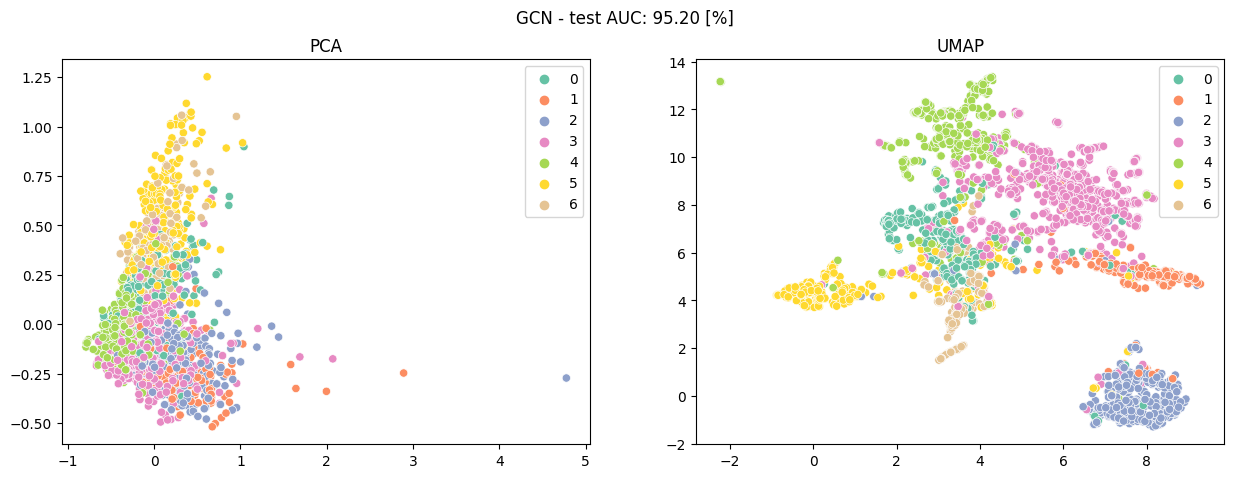

In [6]:
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import GCNConv

from src.trainer import get_default_trainer
from src.utils import visualize_embeddings


class GCNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


    
def evaluate_gcn():
    gnn = GCNModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GCN",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GCN - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_gcn()

## 1.4. Graph Sample and Aggregate (GraphSAGE)
W 2017 roku Hamilton opublikował [pracę](https://arxiv.org/pdf/1706.02216.pdf), w której rozważał induktywne uczenie grafowych sieci neuronowych oraz zaproponował sposób na osiągnięcie lepszej skalowalności metod GNNowych. Zaproponowana metoda (a właściwie rodzina metod) opiera się na idei próbkowania sąsiedztwa grafu (losowo wybrany podzbiór sąsiadów danego węzła) i następnie agregacji cech tak uzyskanej próbki sąsiadów. Zostały rozważone 3 metody agregacji: uśrednienie, LSTM oraz max pooling. Metoda była inspirowana bezpośrednio algorytmem Weisfeiler-Lehman test, a reguła propagacji jest zdefiniowana następująco (z perspektywy pojedynczego wierzchołka):

$$h^{(l)}_{\mathcal{N}(u)} = \text{AGGREGATE}^{(l)}(\{h^{(l)}_v, \forall v\in\mathcal{N}(u) \}) $$
$$h^{(l+1)}_u = W^{(l)} \cdot \text{CONCAT}(h^{(l)}_u, h^{(l)}_{\mathcal{N}(u)})$$

Widzimy zatem, że najpierw agregujemy cechy sąsiadów za pomocą wybranej metody agregacji, a następnie konkatenujemy wektor cech danego wierzchołka ze zagregowanym wektorem sąsiadów, po czym przemnażamy taki wektor przez macierz wag.

W PyTorch-Geometricu, metoda GraphSAGE (tutaj: `SAGEConv`) jest zaimplementowana delikatnie inaczej – reguła propagacji jest określona następująco (dla wariantu z uśrednieniem):

$$h^{(l+1)}_u = W^{(l)}_1 \cdot h^{(l)}_u + W^{(l)}_2 \cdot \text{mean}_{v\in\mathcal{N}(u)} h^{(l)}_v$$

Cechy danego wierzchołka i zagregowanego sąsiedztwa są przekształcane przez osobne wyuczalne macierze.

Analogicznie do modelu GCN przeprowadźmy ewaluację:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type           | Params
--------------------------------------------------------
0 | _gnn                 | GraphSAGEModel | 799 K 
1 | _classification_head | Sequential     | 17.4 K
2 | _loss_fn             | NLLLoss        | 0     
--------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

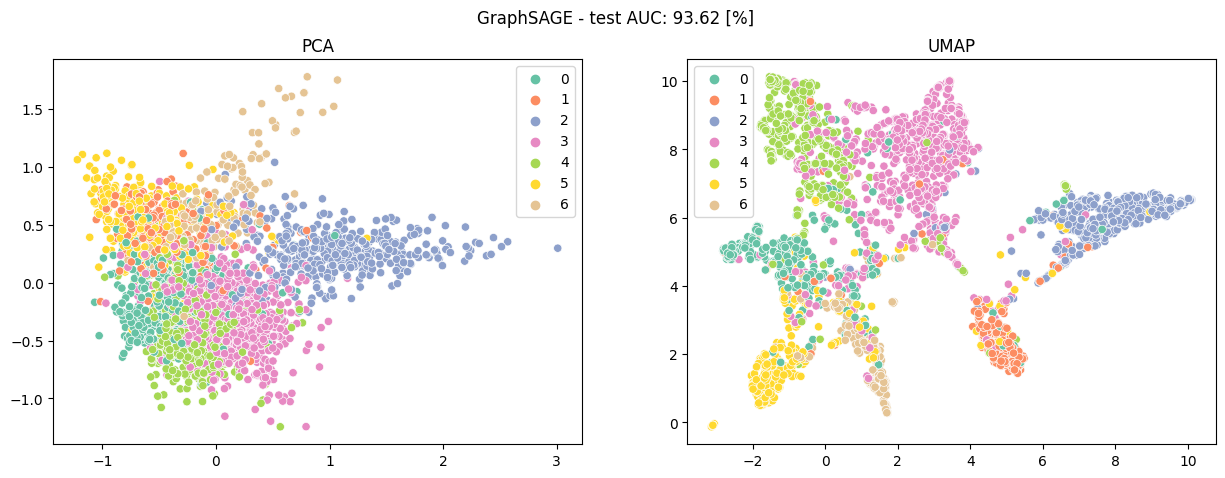

In [7]:
from torch_geometric.nn import SAGEConv


class GraphSAGEModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_graphsage():
    gnn = GraphSAGEModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GraphSAGE",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GraphSAGE - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_graphsage()

## 1.5. Graph Attention Network (GAT)
Również w 2017 roku, Velickovic opublikował [pracę](https://arxiv.org/pdf/1710.10903.pdf), która przetłumaczyła mechanizm uwagi znany z przetwarzania języka naturalnego do dziedziny grafów. Powstała metoda nazywana Graph Attention (GAT). Reguła propagacji jest określona następująco:

$$h^{(l+1)}_u = \alpha_{u,u} W^{(l)}h^{(l)}_u + \sum_{v \in \mathcal{N}(u)} \alpha_{u,v}W^{(l)}h^{(l)}_v $$

$$\alpha_{i, j} = \frac{\exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_j]))}{\sum_{k\in i\cup \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_k]))},$$

gdzie:
- $W^{(l)}$ to wyuczalna macierz parametrów
- $a$ to wyuczalne parametry mechanizmu uwagi (ang. *attention parameters*)
- $\alpha$ to współczynniki mechanizmu uwagi (ang. *attention coefficients*)

Metoda pozwala również na wykorzystanie wielu głowic uwagi (ang. *multi-headed attention*).

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GATModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

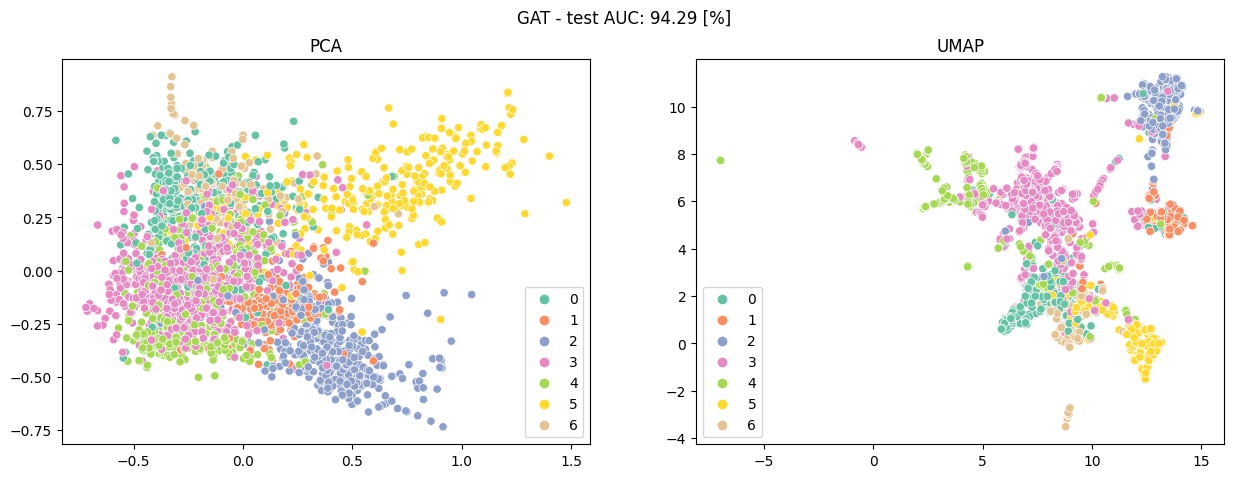

In [8]:
from torch_geometric.nn import GATConv


class GATModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_gat():
    gnn = GATModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GAT",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GAT - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_gat()

In [9]:
import os
os.environ['TENSORBOARD_BINARY'] = 'C:/Users/Iga Miller/OneDrive/Pulpit/Studia_mgr_SI/venv/Scripts/tensorboard'

In [10]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\Iga Miller\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Iga Miller\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\tensorboard\main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "C:\Users\Iga Miller\OneDrive\Pulpit\Studia_mgr_SI\venv\lib\site-packages\absl\app.py", line 254, in _run_main
    sys.exit(main(argv))
  Fi

# Zadania

## 1.1. Opis i ewaluacja wybranej warstwy GNN (3 pkt)
Korzystając z listy zaimplementowanych w PyTorch-Geometricu warstw grafowych sieci neuronowych, wybierz jedną z nich, a następnie:

a) Sprawdź jak w tej warstwie realizowana jest reguła propagacji – porównaj wzór z wyżej badanymi modelami oraz zastanów się jak rozumiesz zasadę działania. **Na zajęciach, powinieneś potrafić to wyjaśnić własnymi słowami.**

b) Analogicznie do modeli GCN, GraphSAGE oraz GAT, zaimplementuj model dwuwarstwowy i przeprowadź jego ewaluację w zadaniu nadzorowanej klasyfikacji wierzchołków.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type             | Params
----------------------------------------------------------
0 | _gnn                 | SelectedGNNModel | 1.2 M 
1 | _classification_head | Sequential       | 17.4 K
2 | _loss_fn             | NLLLoss          | 0     
----------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

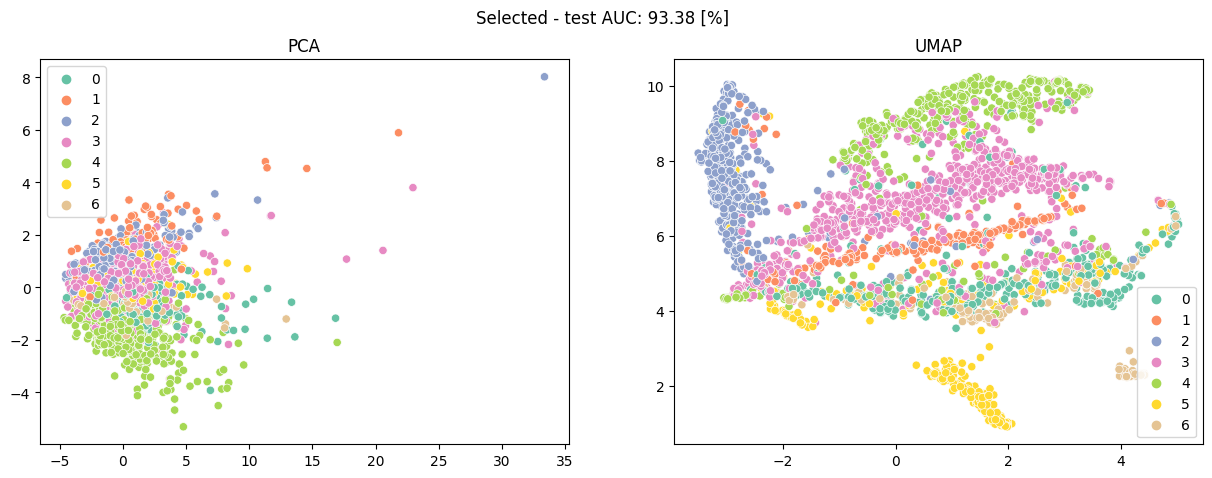

In [10]:
from torch_geometric.nn import ChebConv

class SelectedGNNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, 3)
        self.act1 = nn.ReLU()
        self.conv2 = ChebConv(hidden_dim, out_dim, 3)
        self.act2 = nn.ReLU()
        
    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_selected_gnn():
    gnn = SelectedGNNModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_Selected",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"Selected - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_selected_gnn()

## 1.2. Badanie głębokości grafowej sieci neuronowej (5 pkt)
a) Dla trzech powyżej przedstawionych modeli GNNowych oraz wybranej w zadaniu 1.1 warstwy, zaimplementuj klasę, która utworzy grafową sieci neuronową z dowolnie określoną liczbą warstw (w poprzednich przykładach używaliśmy 2-warstowego GNNa) zadanego typu.

b) Zbadaj jak głębokość grafowej sieci neuronowej wpływa na jakość uzyskiwanych reprezentacji (uwzględniając miarę AUC na zbiorze testowym). Wybierz kilka wartości dla liczby warstw i przedstaw wyniki w tabelce. Pamiętaj aby każdy eksperyment powtórzyć kilkukrotnie i podać wynik uśredniony wraz z odchyleniem standardowym. Skomentuj wyniki.

**[Zadanie dodatkowe]** *c) Znajdź w literaturze jak nazywa się to zaobserwowane zjawisko i wytłumacz własnymi słowami na czym polega.* 

In [11]:
import pandas as pd
import torch
from statistics import mean, stdev

class NLayerGNN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        layer_name: str,
        num_layers: int,
    ):
        super().__init__()
        self.layers = nn.ModuleList()
        
        for _ in range(num_layers-1):
            layer = self._make_layer(layer_name, in_dim, hidden_dim)
            self.layers.append(layer)
            in_dim = hidden_dim
        
        self.final_layer = self._make_layer(layer_name, hidden_dim, out_dim)

    @staticmethod
    def _make_layer(layer_name: str, in_dim: int, out_dim: int):
        if layer_name == 'GCN':
            return GCNConv(in_dim, out_dim)
        elif layer_name == 'SAGEConv':
            return SAGEConv(in_dim, out_dim)
        elif layer_name == 'GAT':
            return GATConv(in_dim, out_dim)
        elif layer_name == 'ChebConv':
            return ChebConv(in_dim, out_dim, 3)
        else:
            raise ValueError(f"Unknown layer name: {layer_name}")

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, edge_index)
            x = torch.relu(x)
        x = self.final_layer(x, edge_index)
        x = torch.relu(x)
        return x
    
        

def evaluate_num_layers():
    num_layers = [2, 3, 4, 8, 10]  # Values for the number of layers to evaluate
    num_experiments = 5  # Number of experiments to average the results

    layer_names = ['GCN', 'SAGEConv', 'GAT', 'ChebConv']
    summary = []
    
    for layer_name in layer_names:
        results = []
        for num_layer in num_layers:
            aucs = []  # Store AUC scores for each experiment
            for _ in range(num_experiments):
                gnn = NLayerGNN(
                    in_dim=datamodule.num_node_features,
                    hidden_dim=hparams["hidden_dim"],
                    out_dim=hparams["emb_dim"],
                    layer_name=layer_name,
                    num_layers=num_layer
                )

                model=SupervisedNodeClassificationGNN(
                gnn=gnn, 
                emb_dim=hparams["emb_dim"],
                num_classes=datamodule.num_classes,
                )

                trainer = get_default_trainer(
                num_epochs=hparams["num_epochs"],
                model_name="supervised_all",
                )

                trainer.fit(model=model, datamodule=datamodule)

                test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
                aucs.append(test_auc)
            summary.append([layer_name,num_layer, mean(aucs), stdev(aucs)])
            print(f"-- Node prediction with {layer_name} {num_layer} layers--")
            print(f"Test AUC: {mean(aucs)} +- {stdev(aucs)}")
    
    summary_df = pd.DataFrame(summary, columns=['layer name','layers number', 'test AUC', 'test std'])
    print(summary_df)

evaluate_num_layers()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GCN 2 layers--
Test AUC: 0.9409439680019283 +- 0.004574169597417682



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 465 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
483 K     Trainable params
0         Non-trainable params
483 K     Total params
1.933     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 465 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
483 K     Trainable params
0         Non-trainable params
483 K     Total params
1.933     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 465 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
483 K     Trainable params
0         Non-trainable params
483 K     Total params
1.933     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 465 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
483 K     Trainable params
0         Non-trainable params
483 K     Total params
1.933     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 465 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
483 K     Trainable params
0         Non-trainable params
483 K     Total params
1.933     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GCN 3 layers--
Test AUC: 0.9472405449605548 +- 0.006110234793474274



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 531 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.196     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 531 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.196     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 531 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.196     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 531 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.196     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 531 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
548 K     Trainable params
0         Non-trainable params
548 K     Total params
2.196     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GCN 4 layers--
Test AUC: 0.9345975585261115 +- 0.012241322876825202



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 794 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 794 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 794 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 794 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 794 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     Total params
3.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GCN 8 layers--
Test AUC: 0.888975627463939 +- 0.013962302671696255



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 926 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.775     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 926 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.775     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 926 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.775     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 926 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.775     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 926 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
943 K     Trainable params
0         Non-trainable params
943 K     Total params
3.775     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GCN 10 layers--
Test AUC: 0.8396223102786649 +- 0.03893351876966095



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 799 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 799 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 799 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 799 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 799 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with SAGEConv 2 layers--
Test AUC: 0.9389542835635044 +- 0.006200722074851719



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 930 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 930 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 930 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 930 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 930 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.793     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with SAGEConv 3 layers--
Test AUC: 0.9452113845654286 +- 0.004584814673522743



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.1 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.319     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.1 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.319     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.1 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.319     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.1 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.319     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.1 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.319     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with SAGEConv 4 layers--
Test AUC: 0.9347641654670459 +- 0.018465505948429623



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with SAGEConv 8 layers--
Test AUC: 0.8581123426320382 +- 0.030414936639073735



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.9 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.9 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.9 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.9 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.9 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.471     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with SAGEConv 10 layers--
Test AUC: 0.8108142001889541 +- 0.043722687112447214



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GAT 2 layers--
Test AUC: 0.9476491042822541 +- 0.00781963443268308



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 467 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 467 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 467 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 467 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 467 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GAT 3 layers--
Test AUC: 0.9447836657803492 +- 0.008369138570798094



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 533 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 533 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 533 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 533 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 533 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GAT 4 layers--
Test AUC: 0.9404055452047907 +- 0.007121043282115004



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 798 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 798 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 798 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 798 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 798 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
816 K     Trainable params
0         Non-trainable params
816 K     Total params
3.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GAT 8 layers--
Test AUC: 0.9035971662828325 +- 0.008031327233892325



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 931 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 931 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 931 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 931 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 931 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.794     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with GAT 10 layers--
Test AUC: 0.865206886983544 +- 0.06119824582358886



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.2 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.2 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.2 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.2 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.2 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.867     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with ChebConv 2 layers--
Test AUC: 0.9330846672340993 +- 0.004802067474086961



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.654     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.654     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.654     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.654     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.654     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with ChebConv 3 layers--
Test AUC: 0.9524983857787792 +- 0.0030248409111736747



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 1.6 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with ChebConv 4 layers--
Test AUC: 0.9551565628625402 +- 0.005592283692402179



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.4 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Node prediction with ChebConv 8 layers--
Test AUC: 0.9169099466788598 +- 0.031542320731045285



  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.8 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.166    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.8 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.166    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.8 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.166    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.8 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.166    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | NLayerGNN  | 2.8 M 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.166    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

-- Node prediction with ChebConv 10 layers--
Test AUC: 0.820331390509666 +- 0.06462029702145568
   layer name  layers number  test AUC  test std
0         GCN              2  0.940944  0.004574
1         GCN              3  0.947241  0.006110
2         GCN              4  0.934598  0.012241
3         GCN              8  0.888976  0.013962
4         GCN             10  0.839622  0.038934
5    SAGEConv              2  0.938954  0.006201
6    SAGEConv              3  0.945211  0.004585
7    SAGEConv              4  0.934764  0.018466
8    SAGEConv              8  0.858112  0.030415
9    SAGEConv             10  0.810814  0.043723
10        GAT              2  0.947649  0.007820
11        GAT              3  0.944784  0.008369
12        GAT              4  0.940406  0.007121
13        GAT              8  0.903597  0.008031
14        GAT             10  0.865207  0.061198
15   ChebConv              2  0.933085  0.004802
16   ChebConv              3  0.952498  0.003025
17   ChebConv         

In [ ]:
# Najlepsze wyniki uzyskano dla modeli z 2,3 lub 4 warstwami. Najlepszy wynik uzyskał model ChebConv dla 4 warstw: 95.5 % +- 0.0055. Zwiększanie liczby warstw do np. 8 czy 10 pogarszało AUC i zwiększało odchylenie standardowe. 